### Pipeline 2 - Exploring games related to Port Royale 4

In our codes for P1, we show that text-mining on reviews of Port Royale 4 is feasible and informative for providing a summary of the game from the perspective of gamers. In this summary, an user may observe features/descriptions that he/she is really worried about and wants to explore other gaming options. This can happen even for games that are overwhelmingly rated positive.

To assist our user to check out gaming alternatives that take into account their concerns, we need to first identify game candidates that are related to the game our user is looking into. This notebook provides the pipeline needed for this process. We will  again to use Port Royale 4 as an exmple for code testing.

### Step 1: Webscrapping tags associated with Port Royale 4

We will get the taps for Port Royale 4, 3, and 3 as to check the robustness of our webscrapping method.

In [1]:
#port royale 4 (mixed)
gameID1 = 1024650
#port royale 3 (mostly positive)
gameID2 = 205610
#port royale 2 (mixed)
gameID3 = 12470
gameIDs = [gameID1, gameID2, gameID3]

In [10]:
import requests
from bs4 import BeautifulSoup as bs
import re

In [11]:
def extract_tags(gameID):
    game_url = 'https://store.steampowered.com/app/' + str(gameID)
    game_page = requests.get(game_url)
    game_soup = bs(game_page.content, 'html.parser')
    game_tag_html = game_soup.find_all('a', class_="app_tag")
    game_tag_list = []
    for tag in game_tag_html:
        match = re.search(r'\s*(\w*)\s+',tag.get_text())
        if match:
            game_tag_list.append(match.group(1))
    return game_tag_list

In [21]:
game_tag_list = []
for gameID in gameIDs:
    game_tag_list.append(extract_tags(gameID))
    print('Tags for game ID', gameID, ': ', extract_tags(gameID))

Tags for game ID 1024650 :  ['Strategy', 'Simulation', 'Trading', 'Economy', 'Management', 'Pirates', 'Naval', 'Sailing']
Tags for game ID 205610 :  ['Strategy', 'Trading', 'Simulation', 'Economy', 'Pirates', 'Management', 'Naval', 'Action', 'Historical', 'Naval', 'Open', 'Sailing', 'Singleplayer', 'Adventure']
Tags for game ID 12470 :  ['Strategy', 'Trading', 'Economy', 'Pirates', 'Naval', 'Historical', 'City']


### Step 2: Weight the importance of the extracted tags

On every tage availabe on steam, the frequency for its appearance across games on steam has been computed. Arraanged in a descending order of one's appearing frequency, these tags are displayed at https://store.steampowered.com/tag/browse/#global_492.

We will use this ordering to re-order our extracted tags so that the final ordering of our extracted tags reflects their importance on steam.

In [74]:
def extract_popular_steam_tags():
    tag_url = 'https://store.steampowered.com/tag/browse/#global_492'
    tag_page=requests.get(tag_url)
    tag_soup = bs(tag_page.content,'html.parser')
    tag_html = tag_soup.find_all('div',class_='tag_browse_tag')
    tag_list = []
    for tag in tag_html:
        match = re.search(r'<div class="tag_browse_tag" data-tagid="(\d*)">(\w*)</div>'
                              ,str(tag))
        if match:
            tag_list.append([match.group(2),match.group(1)])
    return tag_list

In [76]:
popular_tag = extract_popular_steam_tags()
print('Top 5 popular tags & their tagIDs on steam are (in descending order): '
      , extract_popular_steam_tags()[:5])

Top 5 popular tags & their tagIDs on steam are (in descending order):  [['Indie', '492'], ['Action', '19'], ['Adventure', '21'], ['Casual', '597'], ['Simulation', '599']]


In [79]:
## We build a dictionary that weight the popular tags extracted from steam
def build_tag_dict(popular_tag):
    max_score = len(popular_tag)
    tag_dict = {}
    count = 0
    for tag, tag_ID in popular_tag:
        tag_dict[tag] = [max_score - count, tag_ID]
        count = count + 1
    return tag_dict 

In [80]:
tag_dict = build_tag_dict(popular_tag)
for key in list(tag_dict.keys())[:5]:
    print(key, ': ', tag_dict[key])

Indie :  [250, '492']
Action :  [249, '19']
Adventure :  [248, '21']
Casual :  [247, '597']
Simulation :  [246, '599']


In [47]:
import pandas as pd

In [69]:
def sort_tag(tag_dict, tag_list):
    data = []
    for tag in tag_list:
        if tag in tag_dict:
            data.append([tag, tag_dict[tag]])
        else:
            print('The unpopular tag ', "'", tag, "'", 'is removed.')
    df = pd.DataFrame(data, columns = ['Tag','Weight'])
    sorted_df = df.sort_values(by=['Weight'],ascending=False)
    sorted_tag_list = sorted_df.iloc[:,0].tolist()
    return sorted_tag_list

In [71]:
sorted_game_tag_list = []
for tag_list in game_tag_list:
    temp_list = sort_tag(tag_dict,tag_list)
    sorted_game_tag_list.append(temp_list)
    print(temp_list)

['Simulation', 'Strategy', 'Management', 'Economy', 'Trading', 'Pirates', 'Naval', 'Sailing']
The unpopular tag  ' Open ' is removed.
['Action', 'Adventure', 'Simulation', 'Strategy', 'Singleplayer', 'Management', 'Historical', 'Economy', 'Trading', 'Pirates', 'Naval', 'Naval', 'Sailing']
The unpopular tag  ' City ' is removed.
['Strategy', 'Historical', 'Economy', 'Trading', 'Pirates', 'Naval']


### Step 3: Search for games related to our selected game

After sorting the tags used for our game of concern, we search for other existing games on steam that also share these tags. Since the lists of tags used in 2 different games are unlikely to be the same, for simplicity of establishing a pipeline, we only search of games that share the 2 most popular tag identifed in our game of concern. These tags correspond to the number 1 and the number 2 elements of our sorted list of tag. Again, we use Port Royale 4 as a demo for code building. Also, we only search for new-release games at the current moment; otherwise the time to download reviews, especially for old, popular games, is enormous.

P.S. There seems to be a limit of 50 on the number of games that we can access without invoking the use of a browser. Thus, we only work on 50 games at the moment.

In [101]:
target_game_tag_list = sorted_game_tag_list[0][:2]
target_game_tag_list[0], target_game_tag_list[1]

('Simulation', 'Strategy')

In [174]:
#target_search_url = 'https://store.steampowered.com/search/?tags=' + tag_dict[target_game_tag_list[0]][1] + '%2C' + tag_dict[target_game_tag_list[1]][1]

target_search_url = 'https://store.steampowered.com/search/?sort_by=Released_DESC&tags=' + tag_dict[target_game_tag_list[0]][1] + '%2C' + tag_dict[target_game_tag_list[1]][1]

In [175]:
def get_related_game_and_ID(target_search_url):
    page = requests.get(target_search_url)
    soup = bs(page.content, 'html.parser')
    html = soup.find_all('a',class_='search_result_row')
    game_search_result = []
    for info in html:
        match_id = re.search(r'[.\n]*data-ds-appid="(\d+)',str(info))
        match_name = re.search(r'.*https://store.steampowered.com/app/\d+/(.+)/' ,str(info))
        if match_id and match_name:
            game_search_result.append([match_name.group(1), match_id.group(1)])
    return game_search_result

In [176]:
game_search_result = get_related_game_and_ID(target_search_url)

In [177]:
print('Top 5 results from searching '
      ,target_game_tag_list[0]
      ,'games and '
      ,target_game_tag_list[1]
      ,'games')
for name, ID in game_search_result[:5]:
    print('Game Name: ', name, '; App ID: ', ID)

Top 5 results from searching  Simulation games and  Strategy games
Game Name:  Arma_3_Creator_DLC_SOG_Prairie_Fire ; App ID:  1227700
Game Name:  Fimbul_Winter ; App ID:  1605590
Game Name:  SpaceShips ; App ID:  1605950
Game Name:  Disgraced_Hands_of_Fate_DLC ; App ID:  1628220
Game Name:  Throw_Knives ; App ID:  1610660


### Step 4: Text-mining for reviews of games related to our selected game

Now, we have obtained a list of latest-release games sharing the tags, Simulation & Strategy. We want to extract reviews as well as players' play time in a per-user manner for these games.

To do the above task, we can re-use our pipeline in "P1_Sentiment_analyses_NLP_on_reviews_along_a_game_series" to download players' reviews. However, we are still missing a pipeliine to identify the play time of each player as well as game descriptions found in his/her review to him/her, followed by saving the result in a .cvs format. Also, the obtained descriptions for each game should also be saved.

In this session, we will attempt to build this pipeline.

In [268]:
#We re-use our old pipeline
import json
import steamreviews
import os
from io import StringIO

gameID1 = 1024650

df = pd.DataFrame(game_search_result, columns = ['Name','App ID'])

out_file_name = 'Data/Search_result_for_' + str(gameID1) + '.csv'
df.to_csv(out_file_name, index=False, encoding='utf-8')

In [269]:
## We now load in the save search results and download reviews for all of them
def load_search_and_download(out_file_name):
    json_abspath = os.path.abspath(out_file_name)
    df = pd.read_csv(out_file_name)
    gameIDs = df['App ID'].to_list()
    steamreviews.download_reviews_for_app_id_batch(gameIDs)
    return gameIDs

In [270]:
gameIDs = load_search_and_download(out_file_name)

Loading idprocessed_on_20210506.txt
Skipping previously found appID = 1227700
Skipping previously found appID = 1605590
Skipping previously found appID = 1605950
Skipping previously found appID = 1628220
Skipping previously found appID = 1610660
Skipping previously found appID = 1603370
Skipping previously found appID = 1090760
Skipping previously found appID = 1176187
Skipping previously found appID = 1593180
Skipping previously found appID = 1591930
Skipping previously found appID = 483330
Skipping previously found appID = 1460540
Skipping previously found appID = 1528120
Skipping previously found appID = 1577860
Skipping previously found appID = 1606950
Skipping previously found appID = 1261200
Skipping previously found appID = 1392340
Skipping previously found appID = 1551080
Skipping previously found appID = 1088484
Skipping previously found appID = 1439220
Skipping previously found appID = 1568240
Skipping previously found appID = 1623280
Skipping previously found appID = 1458540

In [271]:
#We reuse old pipeline starting from here.
def extract_reviews_to_csv(gameID):
    json_path = 'data/review_' + str(gameID) +'.json'
    json_abspath = os.path.abspath(json_path)
    f = open(json_abspath, 'r')
    data = json.load(f)
    review_list = []
    #Below, we make use of the fact that
    #each review stored in 'data['reviews']' is stored as a tuple {user ID, details of the review},
    #and each 'details of the review' is itself a dictationary.
    #This can be converted into a nested dictinoary using data['reviews'].items(), so that user ID
    #become the key and the details of the review becomes the corresponding value.
    for user_id, review_info in data['reviews'].items():
        #For each item, we build our own disctionary, selecting info we care at the moment
        review_select = {
            'Steam ID': user_id,
            'Review': review_info['review'],
            'Language': review_info['language'],
            'Recommended': review_info['voted_up'],
            'Play time': review_info['author']['playtime_forever'],
            'Purchase': review_info['steam_purchase']
        }
        review_list.append(review_select)
    review_deposit = json.dumps(review_list, indent=4)
    #convert json object to csv
    df = pd.read_json(StringIO(review_deposit))
    out_file_name = os.path.dirname(json_abspath) + '/review_' + str(gameID) + '.csv'
    df.to_csv(out_file_name, index=False, encoding='utf-8')
    print('Reviews being saved to:', out_file_name)

In [272]:
for gameID in gameIDs: extract_reviews_to_csv(gameID)

Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Capstone_Interview/data/review_1227700.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Capstone_Interview/data/review_1605590.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Capstone_Interview/data/review_1605950.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Capstone_Interview/data/review_1628220.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Capstone_Interview/data/review_1610660.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Capstone_Interview/data/review_1603370.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Capstone_Interview/data/review_1090760.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Capstone_Interview/data/review_1176187.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Capstone_Interview/data/review_1593180.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Cap

In [273]:
def build_pd(gameID):
    json_path = 'data/review_' + str(gameID) +'.csv'
    json_abspath = os.path.abspath(json_path)
    df = pd.read_csv(json_abspath)
    #We at this stage only analyze reviews in English.
    df = df[df['Language'] == 'english']
    df['Review'] = df['Review'].astype(str)
    #remove unnecessary key
    df = df.drop(['Steam ID'], axis=1)
    #add a key for word count in the review
    df['Length'] = df['Review'].apply(lambda x : len(x.split()))
    recommend_df = df[df['Recommended'] == True]
    recommend_df = recommend_df.reset_index(drop=True)
    not_recommend_df = df[df['Recommended'] == False]
    not_recommend_df = not_recommend_df.reset_index(drop=True)
    return recommend_df, not_recommend_df

In [274]:
import os
def is_non_zero_file(json_path):  
    return os.path.isfile(json_path) and os.path.getsize(json_path) > 1

In [275]:
recommend_df_L = []
not_recommend_df_L = []
for gameID in gameIDs:
    json_path = 'data/review_' + str(gameID) +'.csv'
    json_abspath = os.path.abspath(json_path)
    if is_non_zero_file(json_abspath):
        df1, df2 = build_pd(gameID)
        recommend_df_L.append(df1)
        not_recommend_df_L.append(df2)

In [264]:
import string
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [276]:
def clean_text(df):
    max_iter = len(df)
    #build a table to translate each punctuation to empty text.
    table = str.maketrans('', '', string.punctuation)
    #build a list of stopwords based on an existing library
    stop_words = stopwords.words('english')
    #for transforming each word into its root
    porter = PorterStemmer()
    for i in range(0,max_iter):
        text_raw_str = df.iloc[i]['Review']
        tokens = word_tokenize(text_raw_str)
        tokens_lower = [w.lower() for w in tokens]
        tokens_no_punct = [w.translate(table) for w in tokens_lower]
        words = [word for word in tokens_no_punct if word.isalpha()]
        words = [w for w in words if not w in stop_words]
        words_root = [porter.stem(word) for word in words]
        separator = ' '
        text_clean_str = separator.join(words_root)
        df.at[i, 'Review'] = text_clean_str
    return df

In [280]:
rec_clean_df_L = []
not_rec_clean_df_L = []
count = 0
for df in recommend_df_L: 
    rec_clean_df_L.append(clean_text(df))
for df in not_recommend_df_L: 
    not_rec_clean_df_L.append(clean_text(df))

In [281]:
from sklearn.feature_extraction.text import CountVectorizer

#Please be aware that many of the text cleaning above can be done within
#CountVectorizer, except I am not familiair enough to CountVectorizer yet.

In [283]:
#Concatenate cleaned text
rec_clean_df_whole = []
rec_clean_df_whole.append(pd.concat(rec_clean_df_L))
not_rec_clean_df_whole = []
not_rec_clean_df_whole.append(pd.concat(not_rec_clean_df_L))

In [285]:
def word_count_vect(df):
    count_vect = CountVectorizer(ngram_range=(1,2),
                                stop_words=['game','ca','nt']).fit(df['Review'])

    words = count_vect.transform(df['Review'])
    #the total count for each identified vocabulary
    sum_words = words.sum(axis=0)

    word_count = []
    for word, index in count_vect.vocabulary_.items():
        word_count.append((word, sum_words[0, index]))
    
    sorted_word_count = sorted(word_count, key=lambda x: x[1],
                                reverse=True)

    return sorted_word_count

In [291]:
rec_word_count_whole = []
rec_word_count_whole.append(word_count_vect(rec_clean_df_whole[0]))

not_rec_word_count_whole = []
not_rec_word_count_whole.append(word_count_vect(not_rec_clean_df_whole[0]))

In [296]:
import matplotlib.pyplot as plt

In [319]:
def plot_common_words(rec_word_count_L, not_rec_word_count_L, game_name_L):

    num_row = len(game_name_L)
    plt.figure(figsize=(10,10))
    j = num_row
    for i in range(0,num_row):
        k = i * 2 + 1
        #Let show only the top 20
        data_raw = rec_word_count_L[i][:20]
        x = []  #vocabulary
        y = []  #count
        for data in data_raw:
            x.append(data[0])
            y.append(data[1])

        plt.subplot(j,2,k)
        plt.title(game_name_L[i], fontsize=14)
        plt.barh(x, y)
        plt.ylabel('Descriptions (\'Recommended\')', fontsize=14)
        plt.xlabel('Counts', fontsize=14)
        plt.xlim(0,250)
        plt.gca().invert_yaxis()
        plt.tight_layout(pad=3.0)

    for i in range(0,num_row):
        k = i * 2 + 2
        data_raw = not_rec_word_count_L[i][:20]
        x = []  #vocabulary
        y = []  #count
        for data in data_raw:
            x.append(data[0])
            y.append(data[1])

        plt.subplot(j,2,k)
        plt.title(game_name_L[i], fontsize=14)
        plt.barh(x, y)
        plt.ylabel('Descriptions (\'Not Recommended\')', fontsize=14)
        plt.xlabel('Counts', fontsize=14)
        plt.xlim(0,250)
        plt.gca().invert_yaxis()
        plt.tight_layout(pad=3.0)

    plt.show()

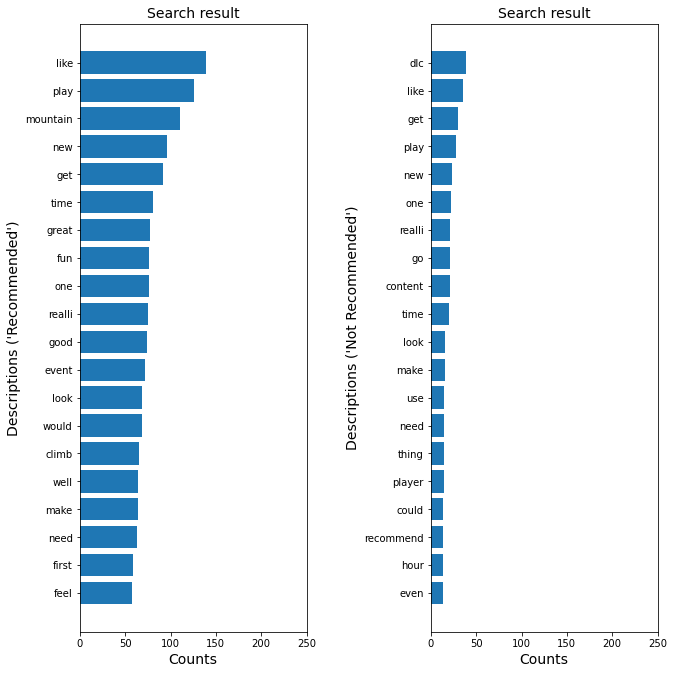

In [320]:
game_name_L = ['Search result']
plot_common_words(rec_word_count_whole, not_rec_word_count_whole, game_name_L)

Text(0.5, 1.0, 'For players not recommeding a game')

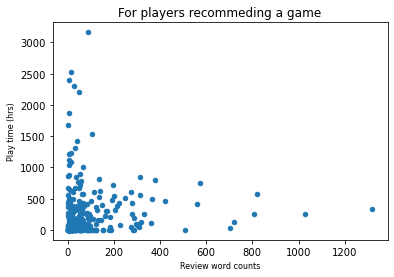

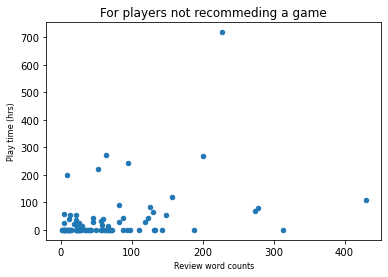

In [318]:
rec_clean_df_whole[0].plot(kind="scatter",x="Length", y="Play time")
plt.xlabel("Review word counts", fontsize=8)
plt.ylabel("Play time (hrs)", fontsize=8)
plt.title('For players recommeding a game')


not_rec_clean_df_whole[0].plot(kind="scatter",x="Length", y="Play time")
plt.xlabel("Review word counts", fontsize=8)
plt.ylabel("Play time (hrs)", fontsize=8)
plt.title('For players not recommeding a game')